# Introduction

In the previous sessions, you learned how to construct scientometric networks in Python. It was clear that this can be quite challenging. VOSviewer takes care of a lot of the necessary work in creating scientometric networks. You can hence use VOSviewer to create networks, which you could then export and analyse further in Python. We will here take this approach.

## VOSviewer

You have previously constructed scientometric networks using VOSviewer. You can import the resulting network for further analysis in `igraph`. In order to import the file in `igraph` you need to have saved both the `map` file and the `network` file in VOSviewer. See the manual of VOSviewer for more explanation. As in the previous Python notebook, we have prepared some files for you, in this case the author collaboration network from the Web of Science files that we analysed previously.

We first import the necessary packages. You will presumably recognize these still from the previous Python notebook.

In [9]:
import pandas as pd
import igraph as ig

import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 10]

Now let us read the map and network file from VOSviewer.

<div class="alert alert-info">
    Read the file <code>data/raw/vosviewer_map.txt</code> using tabs (<code>'\t'</code>) as a field separator, and call the resulting variable <code>map_df</code>.
</div>

In [5]:
map_df = pd.read_csv('../data/raw/vosviewer_map.txt', sep='\t')
map_df

,id,label,x,y,cluster,weight<Links>,weight<Total link strength>,weight<Documents>,weight<Citations>,weight<Norm. citations>,score<Avg. pub. year>,score<Avg. citations>,score<Avg. norm. citations>
0,3,"abad, y.",1.2059,0.3813,19,9,14,3,0,0.0000,2011.0000,0.0000,0.0000
1,9,"abatih, emmanuel",-0.4738,0.1234,3,35,38,5,41,9.1852,2015.2000,8.2000,1.8370
2,11,"abatih, emmanuel nji",-0.2703,0.0869,3,19,27,6,97,11.9346,2014.8333,16.1667,1.9891
3,25,"abdulla, salim",-0.0992,0.3705,1,31,41,4,75,7.6468,2011.7500,18.7500,1.9117
4,31,"abebe, gemeda",-0.8924,-0.2397,2,2,4,2,102,8.9521,2011.0000,51.0000,4.4761
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2229,9457,"zongo, issaka",-0.6405,-0.0871,27,25,33,5,62,3.7447,2008.8000,12.4000,0.7489
2230,9462,"zozo, d.",0.5447,-0.1613,15,4,6,2,0,0.0000,2014.0000,0.0000,0.0000
2231,9464,"zulantay, ines",-0.3783,-0.1794,30,14,21,4,47,2.8640,2012.0000,11.7500,0.7160
2232,9465,"zulu, g.",0.9051,-0.2649,20,15,30,3,9,3.2561,2015.0000,3.0000,1.0854


The network file from VOSviewer has no header, so we set it manually

In [6]:
network_df = pd.read_csv('../data/raw/vosviewer_network.txt', sep='\t', 
                         header=None,
                         names=['idA', 'idB', 'weight'])
network_df

,idA,idB,weight
0,3,601,1
1,3,4575,1
2,3,6635,2
3,3,7417,2
4,3,7567,2
...,...,...,...
15670,9245,9465,2
15671,9257,9337,3
15672,9259,9340,1
15673,9367,9425,1


Now we have loaded the data, so we can simply construct a network as before.

In [7]:
G_vosviewer = ig.Graph.DictList(
      vertices=map_df.to_dict('records'),
      edges=network_df.to_dict('records'),
      vertex_name_attr='id',
      edge_foreign_keys=('idA', 'idB'),
      directed=False
      )

The layout and clustering is also stored by VOSviewer, and we can use that to display the same visualization in `igraph`.

<AxesSubplot:>

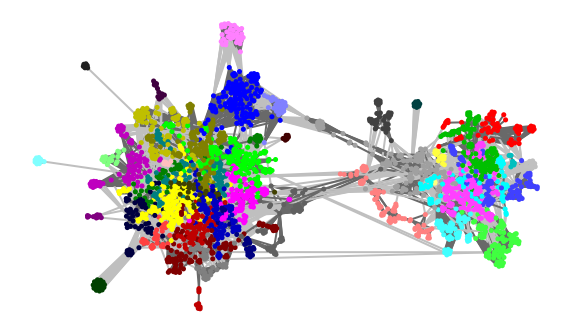

In [16]:
layout = ig.Layout(coords=zip(*[G_vosviewer.vs['x'], G_vosviewer.vs['y']]))
clustering = ig.VertexClustering.FromAttribute(G_vosviewer, 'cluster')

fig, ax = plt.subplots()
ig.plot(clustering, layout=layout, vertex_size=.03, vertex_frame_width=0, vertex_label=None, target=ax)

## Clustering

A common phenomenon in many networks is the presence of group structure, where nodes within the same group are densely connected. Such a structure is sometimes called a *modular* structure, and a frequently used measure of group structure is known as *modularity*. You have already encountered this functionality briefly in VOSviewer, which provides clusters. Here we will explore this a bit more in-depth.

First, we will import a package called `leidenalg` which is the *Leiden algorithm*, which we will use for clustering. It is built on top of `igraph` so that it easily integrates with all the exisiting methods of `igraph`.

In [18]:
import leidenalg

Now let us find clusters in the collaboration network from VOSviewer, using the weight of the edges. Because the algorithm is stochastic, it may yield somewhat different results every time you run it. To prevent that from happening, and to always get the same result, we will set the random seed to 0. The result is a `VertexClustering`, which we already briefly encountered when using the clustering results from VOSviewer.

We will first find clusters using *modularity*.

In [45]:
optimiser = leidenalg.Optimiser()
optimiser.set_rng_seed(0)

clusters = leidenalg.ModularityVertexPartition(G_vosviewer, weights='weight')
optimiser.optimise_partition(clusters)

0.8039560672702035

The length of the `clusters` variable indicates the number of clusters.

In [46]:
len(clusters)

33

When accessing `clusters` variable as a list, each element corresponds to the set of nodes in that cluster.

<div class="alert alert-info">
    What are the nodes in cluster <code>31</code>?
</div>

In [47]:
clusters[31]

[548, 1052, 1075, 1226, 2155]

Hence, node `548`, node `1052`, etc... belong to cluster `31`. Another way to look at the clusters is by looking at the `membership` of `clusters`.

<div class="alert alert-info">
    What is the membership of the first 10 nodes?
</div>

Let us take a closer look at the largest cluster.

In [56]:
H = clusters.giant()
print(H.summary())

IGRAPH U-W- 270 1825 -- 
+ attr: cluster (v), id (v), label (v), score<Avg. citations> (v), score<Avg. norm. citations> (v), score<Avg. pub. year> (v), weight<Citations> (v), weight<Documents> (v), weight<Links> (v), weight<Norm. citations> (v), weight<Total link strength> (v), x (v), y (v), idA (e), idB (e), weight (e)


We could again detect clusters using modularity in the largest cluster.

<AxesSubplot:>

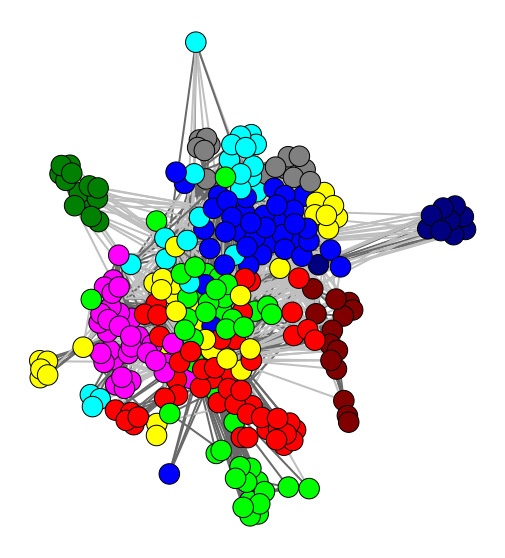

In [57]:
optimiser.set_rng_seed(0)
subclusters = leidenalg.ModularityVertexPartition(H, weights='weight')
optimiser.optimise_partition(subclusters)

fig, ax = plt.subplots()
ig.plot(subclusters, vertex_size=.03, vertex_label=None, target=ax)

In general, modularity will continue to find subclusters in this way, recursively. 

An alternative approach, called CPM (Clique Percolation Method), does not suffer from that problem. 
Let us detect clusters using CPM. We do have to specify a parameter, called the `resolution_parameter`. As its name suggests, it specifies the resolution of the clusters we would like to find. At a higher resolution we will tend to find smaller clusters, while at a lower resolution we find larger clusters. Let us use the resolution parameter 0.01.

In [78]:
optimiser.set_rng_seed(0)
clusters = leidenalg.CPMVertexPartition(G_vosviewer,
                                     weights='weight',
                                     resolution_parameter=0.01)
optimiser.optimise_partition(clusters)
clusters.giant().vcount()

301

In [79]:
len(clusters)

54

<div class="alert alert-info">
Detect subclusters in the largest cluster using CPM, using the same <code>resolution_parameter</code>. How many subclusters do you find? How does that compare to modularity?
</div>

In [80]:
optimiser.set_rng_seed(0)
clusters = leidenalg.CPMVertexPartition(clusters.giant(),
                                     weights='weight',
                                     resolution_parameter=0.01)
optimiser.optimise_partition(clusters)
len(clusters)

1

<div class="alert alert-info">
Try to find more subclusters by specifying a higher <code>resolution_parameter</code>.
</div>

In [88]:
optimiser.set_rng_seed(0)
clusters = leidenalg.CPMVertexPartition(clusters.giant(),
                                     weights='weight',
                                     resolution_parameter=0.01)
optimiser.optimise_partition(clusters)
len(clusters)

1

Modularity adapts itself to the network. In a sense that is convenient, because you then do not have to specify any parameters. On the other hand, it makes the definition of what a "cluster" is less clear.

CPM does not adapt itself to the network, and maintains the same defintion across different networks. That is convenient, because it brings more clarity to what we mean by a "cluster". Whenever you try to find subclusters using the same `resolution_parameter`, CPM should not find any subclusters. In practice, it may happen that CPM still finds some subclusters, in which case the original clusters were actually not the best possible. The Leiden algorithm can be run for multiple iterations, and with each iteration, the chances are smaller that CPM would find such subclusters. Modularity will always find subclusters, independent of the number of iterations.

<div class="alert alert-info">
    Try to optimise the partition further. Note that the function <code>optimise_partition</code> returns how much further it managed to improve the function, so that if it returns <code>0.0</code>, it means it couldn't find any further improvement. Execute the cell repeatedly. Does it return 0.0 after some time?
</div>

0.0

Let us compare the clusters that we detected in Python with the clustering results from VOSviewer.

We can summarize the overall similarity to the partition based on the disciplines using the Normalised Mutual Information (NMI). The NMI varies between 0 and 1 and equals 1 if both are identical.

In [87]:
clusters.compare_to(clustering, method='nmi')

ValueError: the two membership vectors must be equal in length

There are some differences between the clustering from VOSviewer and the clusters we detected in Python. This will of course highly depend on what resolution parameter we have used for both results. One other important difference is that VOSviewer will by default use *normalized* weights. By default, it will divide the weight of a link by the expected weight, assuming that the total link weight of each node would remain the same, which is sometimes referred to as the *association strength*. We also perform this normalization here.

In [89]:
G_vosviewer.es['weight_normalized'] = [
    e['weight']/( G_vosviewer.vs[e.source]['weight<Total link strength>']*G_vosviewer.vs[e.target]['weight<Total link strength>'] / (2*sum(G_vosviewer.es['weight'])) ) 
    for e in G_vosviewer.es]

By default VOSviewer uses the default resolution of `1` for these normalized weights. If we now detect clusters using these weights, you will see that the result are more closely aligned to the VOSviewer results.

In [90]:
clusters = leidenalg.find_partition(G_vosviewer, leidenalg.CPMVertexPartition, 
                                       weights='weight_normalized', resolution_parameter=1,
                                       n_iterations=10)

clusters.compare_to(clustering, method='nmi')

0.950036333966632

Finally, the Leiden algorithm is also directly implemented in `igraph` itself nowadays. It is somewhat less elaborate than the `leidenalg` package, but it is also substantially faster. If you are analysing very large networks, it might be better to use the `igraph` Leiden algorithm. Using it is straightforward.

In [91]:
clusters = G_vosviewer.community_leiden(objective_function='CPM',weights='weight_normalized', 
                                        resolution_parameter=1.0, n_iterations=10)

clusters.compare_to(clustering, method='nmi')

/var/folders/j8/sgmsw3_510nbtw4brgpr222r0000gn/T/ipykernel_3226/1522592867.py:1: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  clusters = G_vosviewer.community_leiden(objective_function='CPM',weights='weight_normalized',


0.9558654064702146

Now let us explore cluster detection a bit further.

<div class="alert alert-info">
    Vary the <code>resolution_parameter</code> when detecting clusters using the CPM method. What <code>resolution_parameter</code> seems reasonable to you, and why?
</div>

In [96]:
clusters = G_vosviewer.community_leiden(objective_function='CPM',weights='weight_normalized', 
                                        resolution_parameter=1.0, n_iterations=10)

clusters.compare_to(clustering, method='nmi')

/var/folders/j8/sgmsw3_510nbtw4brgpr222r0000gn/T/ipykernel_3226/1522592867.py:1: DeprecationWarning: resolution_parameter keyword argument is deprecated, use resolution=... instead
  clusters = G_vosviewer.community_leiden(objective_function='CPM',weights='weight_normalized',


0.9555117479948635

# Document-term clustering

We will now use the same type of clustering technique that we used previously in a slightly different way. Instead of clustering a network, we will cluster a specific type of network, namely a bipartite network. This requires a slightly different (and more complicated) approach. More specifically, we will cluster a document-term network, where documents are linked to terms if those terms appear in a document.

We leave the task of extracting terms to VOSviewer, and simply import the resulting document-term network in Python.

We read two files: (1) the `terms.txt` file, which simply contains the terms and their `id`; and (2) the `doc-term.txt` file, which contains which term occurs in which document. The `document id` refers to the line number of the WoS files that were read by VOSviewer. We will encounter this later.

In [97]:
terms_df = pd.read_csv('../data/raw/terms.txt', sep='\t', index_col='id')
doc_terms_df = pd.read_csv('../data/raw/doc-term.txt', sep='\t')

In this file, both the documents and the terms are using the same numbers, so that `igraph` cannot distinguish them (e.g. there is both a document `1` and a term `1`). We therefore create separate ids for both the documents and the terms.

In [98]:
doc_terms_df['document id'] = doc_terms_df['document id'].map(lambda x: str(x) + '-doc')
doc_terms_df['term id'] = doc_terms_df['term id'].map(lambda x: str(x) + '-term')

We can now create the network.

In [99]:
G_doc_term = ig.Graph.TupleList(
      edges=doc_terms_df.values,
      vertex_name_attr='id',
      directed=False
      )

This is a bipartite network, and we create a specific vertex attribute to indicate what the type is of the node: either a `doc` or a `term`.

In [100]:
G_doc_term.vs['type'] = ['doc' if 'doc' in v['id'] else 'term' for v in G_doc_term.vs]

Similar to the co-authorship network, VOSviewer typically normalizes the weights in a network by using the association strength, and we will also use that here.

In [102]:
G_doc_term.es['weight'] = [2.0*G_doc_term.ecount()/(G_doc_term.vs[e.source].degree()*G_doc_term.vs[e.target].degree()) 
                           for e in G_doc_term.es]

We now employ a small trick in the `leidenalg` package in order to do clustering in a bipartite network. We will not explain the full details here, please see the [documentation](https://leidenalg.readthedocs.io/en/latest/multiplex.html#bipartite) for a brief explanation of this approach. Please note that this approach is *not* possible using the internal `igraph` Leiden algorithm.

In [103]:
partition, partition_docs, partition_terms = leidenalg.CPMVertexPartition.Bipartite(
    G_doc_term, types='type', weights='weight', resolution_parameter_01=1)

We are now ready to detect clusters, but we are going to use all three partitions we created. We do so by using the function `optimise_partition_multiplex` instead of the `optimise_partition` function that we used previously. We have to pass a list of partitions to that function. For the trick to work, we also need to pass the argument `layer_weights=[1,-1,-1]`, which assumes that the `partition` is the first element of the list that we pass.

In [115]:
optimiser = leidenalg.Optimiser()
optimiser.set_rng_seed(0)
optimiser.optimise_partition_multiplex(
              [partition, partition_docs, partition_terms],
              layer_weights=[1,-1,-1], n_iterations=100)

603.6031060570458

Now `partition` contains the clustering results (actually, `partition_docs` and `partition_terms` contain the identical clustering results). We extract the cluster membership of each node, and make it a new node attribute.

In [116]:
G_doc_term.vs['cluster'] = partition.membership
G_doc_term.vs['degree'] = G_doc_term.degree()

We will now create a so-called *projection* of the bipartite graph, which actually simply refers to the creation of a co-occurrence network.

In [120]:
G_doc_term.vs['type_int'] = [1 if v['type'] == 'term' else 0 for v in G_doc_term.vs]
G_terms = G_doc_term.bipartite_projection(types='type_int', which=1)
G_terms.simplify(combine_edges='sum')

G_terms.vs['id'] = [int(v['id'][:-5]) for v in G_terms.vs] # remove the trailing '-term' we added before
G_terms.vs['term'] = [terms_df.loc[v['id'],'term'] for v in G_terms.vs]

Now `G_terms` contains only terms and the co-occurrence between them. We will export this network to a file format so that we can read it back into VOSviewer. First, let us create the output directory (if necessary).

In [121]:
import os
output_dir = '../data/processed/'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

Now we export the network `G_terms` in file format which is understandable to VOSviewer.

In [122]:
nodes_df = pd.DataFrame.from_dict({attr: G_terms.vs[attr] for attr in G_terms.vs.attributes()})
nodes_df['label'] = nodes_df['term']
nodes_df['cluster'] += 1
nodes_df['weight<Occurence>'] = nodes_df['degree']
nodes_df = nodes_df.sort_values('id')
nodes_df[['id', 'label', 'cluster', 'weight<Occurence>']].to_csv(output_dir + 'map_vosviewer.txt', sep='\t', index=False)


edge_df = pd.DataFrame([(G_terms.vs[e.source]['id'], G_terms.vs[e.target]['id'], e['weight']) for e in G_terms.es],
                       columns=['source', 'target', 'weight'])
edge_df = edge_df.sort_values(['source', 'target'])
edge_df.to_csv(output_dir + 'network_vosviewer.txt', sep='\t', index=False, header=False)

The great benefit of doing the clustering in Python is that we now also have a clustering of the publications. This is something that is not possible in VOSviewer.

Let us first load the actual publication files which were used by VOSviewer (we have already done this in the previous notebook). As said, the `document id` refers to the line number of the WoS files that were read by VOSviewer, starting from `1`. We therefore also create a `document id` that is the same.

In [126]:
import glob
import csv
files = sorted(glob.glob('../data/raw/savedrecs_*.txt'))
publications_df = pd.concat(pd.read_csv(f, sep='\t', quoting=csv.QUOTE_NONE, 
                                        usecols=range(68), index_col='UT') for f in files)
publications_df['document id'] = range(1,publications_df.shape[0]+1)

Now let us create a dataframe from `G_doc_term` with all the information from the documents.

In [127]:
nodes_df = pd.DataFrame.from_dict({attr: G_doc_term.vs[attr] for attr in G_doc_term.vs.attributes()})
nodes_df = nodes_df[nodes_df['type'] == 'doc']
nodes_df

,id,type,cluster,degree,type_int
0,1-doc,doc,5,5,0
6,2-doc,doc,5,15,0
21,3-doc,doc,1,7,0
29,4-doc,doc,4,7,0
36,5-doc,doc,2,6,0
...,...,...,...,...,...
2738,2332-doc,doc,2,2,0
2739,2334-doc,doc,1,6,0
2740,2336-doc,doc,0,6,0
2741,2337-doc,doc,5,4,0


Now we need back the original integer `document id`, instead of the identifiers we created `doc-1`, `doc-2`, etc... We can then use those `document id` to merge back the results with the original information from the publications.

In [128]:
nodes_df['document id'] = nodes_df['id'].str[:-4].astype(int)
publications_df = pd.merge(nodes_df[['document id', 'cluster']], publications_df, 
                           left_on='document id', right_on='document id')

Finally, for further inspection, we may want to export our results to a `.csv` file.

In [129]:
publications_df[['AU', 'PY', 'TI', 'SO', 'cluster']].to_csv(output_dir + 'publications_clustering.csv', 
                                                            index=False)